# Постановка задачи

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Нужно построить алгоритм, который  на основании исторических данных о поведении клиентов рекомендовал пользователям новый тариф: «Смарт» или «Ультра».<br>

Нужно построить модель для задачи классификации, которая выберет подходящий тариф. <br> 
Нужно построить модель с максимально большим значением accuracy больше или равно 0.75. 

# Порядок решения задачи

**Шаг 0.** Импортируем все, что нужно - библиотеки и данные и посмотрим, что из себя представляют данные.<br>
**Шаг 1.** Разделим исходные данные на обучающую, валидационную и тестовую выборки.<br>
**Шаг 2.** Выберем целевой признак на основании чего будет происходить классификация клиентов старых тарифов.<br>
**Шаг 3.** Обучим несколько моделей на обучающей выборке и проверим качество обучения на валидационной выборке.<br>
**Шаг 4.** Проанализируем полученные результаты в т.ч. на вменяемость. Если нас устроят результаты, то выберем лучших и перейдем к тесту.<br>
**Шаг 5.** Проверим качество модели на тестовой выборке. Если все устроит, то выберем лучшую модель.<br>
**Шаг 6.** Напишем краткое аналитическое резюме по выбранной модели.

In [72]:
import pandas as pd
import numpy as np
import random
from statistics import mean
import os


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [73]:
path_review = '/datasets/users_behavior.csv'
my_path = '/Users/Ideapad S145/Desktop/Data_Science/05. Модуль Машинное обучение/Проект//users_behavior.csv'
if os.path.exists(path_review):
    df = pd.read_csv(path_review, sep=',')
elif os.path.exists(my_path):
    df = pd.read_csv(my_path, sep=',')
else:
    print("Проверьте правильность пути к датасету")

In [40]:
df.head(3)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Посмотрим что с данными в полях.

Напишем две функции для построения графиков - гистограммы и ящика с усами

In [42]:
# функция, которая строит две гистограммы с оценкой плотности распределения - для ultra и для smart
def hist(column, name_features):
    fig = plt.figure()
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    sns.histplot(x=df[df.is_ultra == 1][column], kde=True, ax=ax_1)
    sns.histplot(x=df[df.is_ultra == 0][column], kde=True, ax=ax_2)
    ax_1.set_title('Гистограмма ' + name_features + ' в ТП Ultra', fontsize=12)
    ax_2.set_title('Гистограмма ' + name_features + ' в ТП Smart', fontsize=12)
    fig.set_figwidth(12)
    fig.set_figheight(5)
    return plt.show()

# функция, которая строит два boxplot'a - для ultra и для smart
def boxplot(column, name_features):
    fig = plt.figure()
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    sns.boxplot(x=df[df.is_ultra == 1][column], ax=ax_1)
    sns.boxplot(x=df[df.is_ultra == 0][column], ax=ax_2)
    ax_1.set_title('Ящик с усами ' + name_features + ' в ТП Ultra', fontsize=12)
    ax_2.set_title('Ящик с усами ' + name_features + ' в ТП Smart', fontsize=12)
    fig.set_figwidth(15)
    fig.set_figheight(3)
    return plt.show()

**Начнем с поля calls**

In [43]:
df.calls.describe()

count    3214.000000
mean       63.038892
std        33.236368
min         0.000000
25%        40.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls, dtype: float64

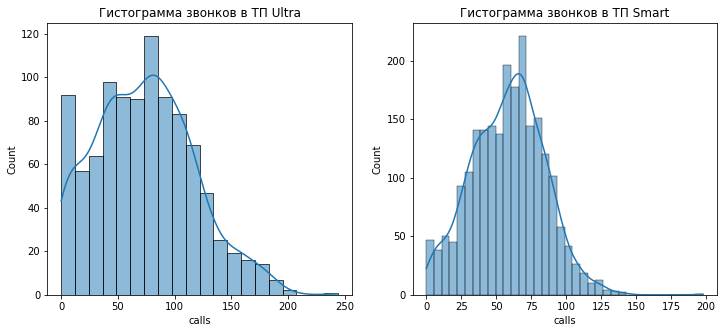

In [44]:
hist('calls', 'звонков')

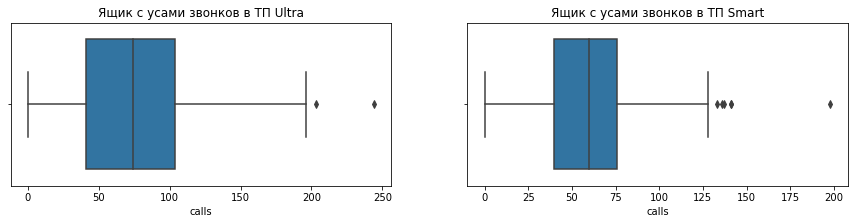

In [45]:
boxplot('calls', 'звонков')

Есть статистические выбросы, которые могут ухудшить обучение модели. Пока все оставим как есть. Если модель будет плохо обучаться, то исключим выборосы из обучения.

**Посмотрим поле messages**

In [46]:
df.messages.describe()

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages, dtype: float64

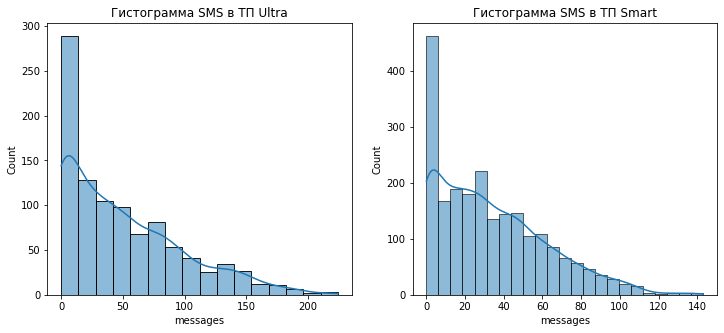

In [47]:
hist('messages', 'SMS')

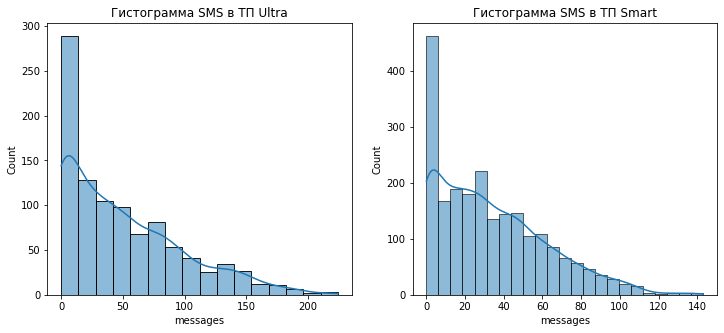

In [48]:
hist('messages', 'SMS')

Тоже выборсы есть и довольно много.

**Посмотрим поле mb_used**

In [49]:
df.mb_used.describe()

count     3214.000000
mean     17207.673836
std       7570.968246
min          0.000000
25%      12491.902500
50%      16943.235000
75%      21424.700000
max      49745.730000
Name: mb_used, dtype: float64

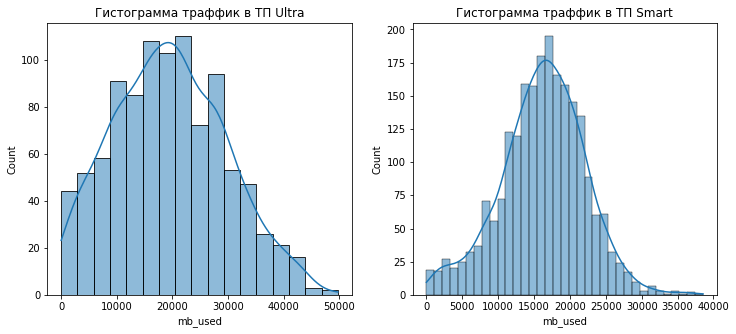

In [50]:
hist('mb_used', 'траффик')

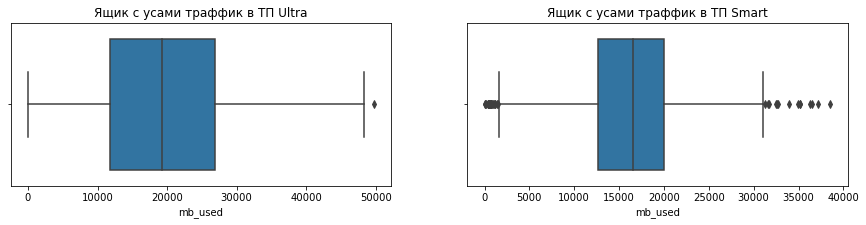

In [51]:
boxplot('mb_used', 'траффик')

Опять же выбросы

Посмотрим структуру пользователей в разрезе тарифных планов

In [52]:
df.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Примерно 2:1 smart к ultra

# Шаг 1. Разделим исходные данные на обучающую, валидационную и тестовую выборки.

У нас клиентов на тарифе smart в два раза больше клиентов на тарифе ultra. Чтобы при делении исходной выборки оставалась такая же пропорция сделаем отдельно обучающие, валидационные и тестовые выборки для каждого тарифного плана, а потом их объединим. В этом случае у нас в каждой выборке будет точно сохранена изначальная пропорция. 

In [53]:
smart = df[df.is_ultra == 0]
ultra = df[df.is_ultra == 1]

Процесс выделения сделаем таким:
1. 50% - обучающая выборка, 25% - валидационная выборка и 25% тестовая выборка.
2. Сначала выберем 25% для теста, а оставшихся поделим на обучение и валидацию.

In [54]:
# выберем 25% для теста
smart_train, smart_test = train_test_split(smart, test_size=0.25, random_state=12345)
ultra_train, ultra_test = train_test_split(ultra, test_size=0.25, random_state=12345)

# выберем 50% на обучение и 25% на валидацию. В этом случае test_size будет равным 0,3333 (1/3)
smart_train, smart_valid = train_test_split(smart_train, test_size=0.3333, random_state=12345)
ultra_train, ultra_valid = train_test_split(ultra_train, test_size=0.3333, random_state=12345)

Теперь склеим обучающие, валидационные и тестовые выборки

In [55]:
df_train = pd.concat([smart_train, ultra_train])
df_valid = pd.concat([smart_valid, ultra_valid])
df_test = pd.concat([smart_test, ultra_test])

In [56]:
# отсортируем по прежним индексам, чтобы повторить прежнюю структуру 
df_train.sort_index(axis=0, inplace=True)
df_valid.sort_index(axis=0, inplace=True)
df_test.sort_index(axis=0, inplace=True)

# Шаг 2. Выберем целевой признак на основании чего будет происходить классификация клиентов старых тарифов.

Очевидно, что целевым признаком должно быть поле is_ultra. У нас получается бинарная классификация клиентов.<br>
Разделим наши выборки на признаки и цели.

In [58]:
train_target = df_train.is_ultra
train_features = df_train.drop('is_ultra', axis=1)

valid_target = df_valid.is_ultra
valid_features = df_valid.drop('is_ultra', axis=1)

test_target = df_test.is_ultra
test_features = df_test.drop('is_ultra', axis=1)

# Шаг 3. Обучим несколько моделей на обучающей выборке и проверим качество обучения на валидационной выборке.

Выберем следующие модели для обучения:
1. Дерево решений.
2. Случайный лес.
3. Логистическая регрессия.

Для Дерево решений и Случайный лес применим разные варианты гиперпараметров - глубина и количестов деревьев.
По каждой нашей модели на валидационной выборке посчитаем accuracy.

В процессе обучения мы будем создавать коллекцию моделей, которые показали лучшие результаты на валидационной выборке. Полученную коллекцию проверим на тестовой выборке и там выберем лучшую модель.

**Начнем с модели Дерево решений.**<br>
Посчитаем 10 вариантов с глубиной от 1 до 10 и сделаем коллекцию в которой будет модель, название, ее параметры и оценка accuracy.

In [59]:
# сделаем список из 10 моделей Дерева решений c глубиной от 1 до 10
models_dtc = []
for depth in range(1, 11):
    model_1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_1.fit(train_features, train_target)
    predictions = model_1.predict(valid_features)
    models_dtc.append([model_1, 'Дерево решений', np.nan, depth, accuracy_score(valid_target, predictions)])

Выберем 3 лучших модели по оценке accuracy

In [60]:
models = sorted(models_dtc, key=lambda x: x[4], reverse=True)[:3]
display(models)

[[DecisionTreeClassifier(max_depth=5, random_state=12345),
  'Дерево решений',
  nan,
  5,
  0.8069738480697385],
 [DecisionTreeClassifier(max_depth=6, random_state=12345),
  'Дерево решений',
  nan,
  6,
  0.7982565379825654],
 [DecisionTreeClassifier(max_depth=7, random_state=12345),
  'Дерево решений',
  nan,
  7,
  0.7957658779576587]]

Все три модели имеют оценку accuracy больше 0,75. Максимальная оценка accuracy на валидационной выборке была получена с гиперпараметром глубины равным 5.

**Возьмем модель Слуйчайный лес.**<br>
Будем варьировать следуюшие гиперпараметры:
1. Глубина деревьев - от 1 до 10.
2. Количестов деревьев - от 10 до 110 с шагом 10

И также как в предудщем варианте сделаем список полученных поделей

In [61]:
models_rfc = []
for est in range(10, 111, 10):
    for depth in range(1, 11):
        model_2 = RandomForestClassifier(random_state=1234, n_estimators=est, max_depth=depth)
        model_2.fit(train_features, train_target)
        predicts_valid = model_2.predict(valid_features)
        models_rfc.append([model_2, 'Случайный лес', est, depth, model_2.score(valid_features, valid_target)])      

Выберем 3 лучших и присоединим к нашей коллекции лучших моделей

In [62]:
rfc_top_3 = sorted(filter(lambda x: x[1] == 'Случайный лес', models_rfc),
                         key=lambda x: x[4],
                         reverse=True)[:3]

models = models + rfc_top_3

In [63]:
# выведем на экран 3ку лучших из серии Случайный лес
display(rfc_top_3)

[[RandomForestClassifier(max_depth=10, n_estimators=90, random_state=1234),
  'Случайный лес',
  90,
  10,
  0.8281444582814446],
 [RandomForestClassifier(max_depth=10, n_estimators=80, random_state=1234),
  'Случайный лес',
  80,
  10,
  0.8268991282689913],
 [RandomForestClassifier(max_depth=10, n_estimators=110, random_state=1234),
  'Случайный лес',
  110,
  10,
  0.8268991282689913]]

Результат accuracy у все трех лучших больше 0,82. Лучшая модель имеет следующий набор гиперпараметров кол-во деревьев = 90, глубина = 10

**Перейдем к следующей модели - Логистическая регрессия**

In [64]:
model_3 = LogisticRegression(random_state=12345)
model_3.fit(train_features, train_target)
print(model_3.score(valid_features, valid_target))

# просто присоединим эту модель к коллекции успешных моделей.
models.append([model_3, 'Логистическая регрессия', np.nan, np.nan, model_3.score(valid_features, valid_target)])

0.7521793275217933


Для наших обучающей и валидационной выборках эта модель показывает худший результат, относительно Дерево решений и Случайный лес, но все равно больше 0,75.

Оценим наши результаты на вменяемость. 
Построим столбец с случайными показателями новой классификации 0 и 1.

In [65]:
print('accuracy_score для случайного выбора =', 
      mean([int(random.randint(0, 1) == df.loc[i, 'is_ultra']) for i in range(len(df))]))

accuracy_score для случайного выбора = 0.5140012445550716


In [66]:
print('accuracy_score для случайного выбора =', mean([int(0 == df.loc[i, 'is_ultra']) for i in range(len(df))]))

accuracy_score для случайного выбора = 0.693528313627878


Таким образом, мы показали, что результаты полученные нашими моделями существенно отличаются от случайного угадывания

**Краткое резюме:**<br>
1. Логистическая регрессия показала худший результат.<br>
2. Лучший результат на валидационной выборке показала модель Случайный лес.<br>
3. Дерево решений тоже показало хороший результат, но чуть хуже чем Случайный лес.<br>

Выберем лучшую модель из нашей полученной коллекции лучших моделей **models**. Эту модель затем проверим на тестовой выборке.

In [67]:
best_model = sorted(models, key=lambda x: x[4], reverse=True)[0]
print('Название модели:', best_model[1])
print('Количество деревьев =', best_model[2])
print('Глубина = ', best_model[3])
print('Accuracy = ', best_model[4])

Название модели: Случайный лес
Количество деревьев = 90
Глубина =  10
Accuracy =  0.8281444582814446


# Шаг 5. Проверим качество моделей на тестовой выборке. Если все устроит, то выберем лучшую модель.

Посмотрим как ведет себя на тестовой выборке наша лучшая модель, выбранная на валидационной выборке.
Рассчитаем для нее accuracy на нашей тестовой выборке.

In [68]:
predictions = best_model[0].predict(test_features)
print('Значение accuracy на тестовой выборке = ', best_model[0].score(test_features, test_target))                               

Значение accuracy на тестовой выборке =  0.8198757763975155


Результаты accuracy на тестовой выборке нашей лучшей модели выбранной по результатам валидационной выборке показали почти такие же результаты, что результаты accuracy на валидационной выборке. Что показывает неплохую обученность модели и устойчивость accuracy при подачи разных выборок на вход модели. 
**Таким образом, мы выбираем модель случайный лес с гиперпараметрами 90 деревьев и максимальная глубина 10. Эта модель получила оценку accuracy на валидационной выборке 0,828, а на тестовой выборке 0,820**